In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Requirements

In [1]:
! pip install pandasql
! pip install simpletransformers
! pip install wandb
! pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 687.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 43.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c4bb98cee0280cea02ae8c0aa7201139a31c2b36ab8b54ba81f6a74b0c4888d6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
from simpletransformers.question_answering import QuestionAnsweringModel
import nltk
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

2024-05-17 15:15:49.062072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 15:15:49.062217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 15:15:49.235379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Helper Functions

In [3]:
# coverting df to training structure
def convert_df_to_structure(df):
    data = []
    for idx, row in df.iterrows():
        qas = [{
            "id": str(idx),
            "is_impossible": False,  # Assuming all questions are possible
            "question": row['Question'],
            "answers": [
                {"text": row['Answer'],
                 "answer_start": 0}  # Assuming answer starts at the beginning
                ]
        }]

        data.append({
            "context": row['Answer'],  # Assuming answer as context
            "qas": qas
        })
    return data

# coverting test data to to_predict format
def convert_to_predict_format(df):
    to_predict = []
    for index, row in df.iterrows():
        context = row['Answer']
        qas = [{
            "question": row['Question'],
            "id": str(index),
        }]
        to_predict.append({"context": context, "qas": qas})
    return to_predict

# function to make a list of dictionaries of actual and predicted sentences for display purposes
def show_actual_pred(model, data_prediction, actual_df):
  show_results = []
  for i in range(10):
    actual_qs = data_prediction[i]['qas'][0]['question']
    actual_ans = actual_df.iloc[i,2]
    answers =  model.predict([data_prediction[i]])
    #print(max(answers[0][0]['answer']))
    pred_ans = str(max(answers[0][0]['answer']))
    show_results.append({'actual_question':actual_qs, 'actual_answer':actual_ans ,'predicted_answer':pred_ans})
  return show_results

# making reference and predicted sentence lists for calculation of bleu and rouge scores
def get_reference_and_predicted_answers(test_data, formatted_test_data, model):
    reference_answers = []
    predicted_answers = []

    for i in range(len(test_data)):
      actual_ans = test_data.iloc[i,2]
      answers =  model.predict([formatted_test_data[i]])
      pred_ans = str(max(answers[0][0]['answer']))
      reference_answers.append(actual_ans)
      predicted_answers.append(pred_ans)

    return reference_answers, predicted_answers

# Data Understanding

In [4]:
# Load your CSV file into a Pandas DataFrame
# df = pd.read_csv("/content/drive/MyDrive/nlp_a5/train.csv")
df = pd.read_csv("/kaggle/input/medquad/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qtype     16407 non-null  object
 1   Question  16407 non-null  object
 2   Answer    16407 non-null  object
dtypes: object(3)
memory usage: 384.7+ KB


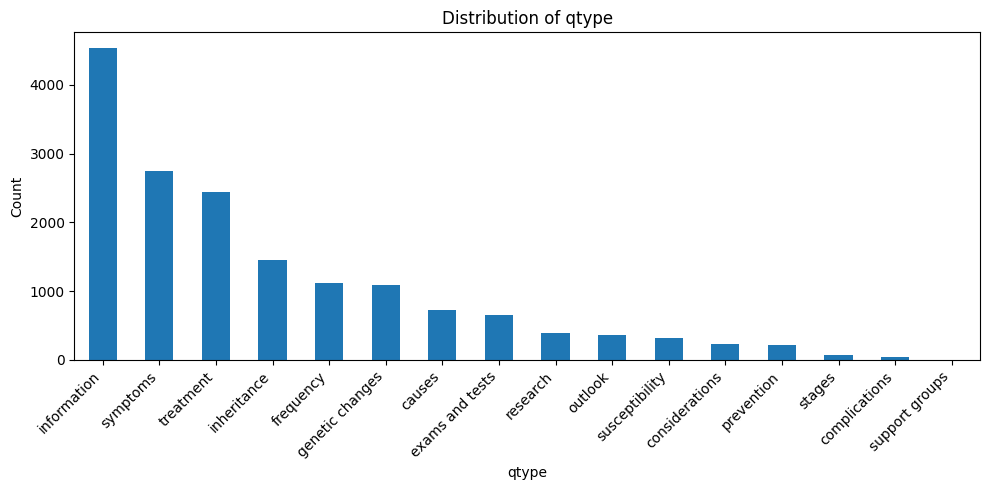

In [5]:
# Get the value counts of 'qtype'
value_counts = df['qtype'].value_counts()

# Plot the distribution as a bar plot
plt.figure(figsize=(10, 5))
value_counts.plot(kind='bar')
plt.title('Distribution of qtype')
plt.xlabel('qtype')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## Quering Dataset

### Find the most common treatments searched by patients

In [6]:
query1 = """
SELECT Question, Answer
FROM df
WHERE qtype = 'treatment'
ORDER BY RANDOM()
LIMIT 5;
"""

result1 = sqldf(query1, globals())
result1

,Question,Answer
0,What are the treatments for Saethre-Chotzen sy...,These resources address the diagnosis or manag...
1,What are the treatments for Amelogenesis imper...,How might amelogenesis imperfecta be treated? ...
2,What are the treatments for histiocytosis-lymp...,These resources address the diagnosis or manag...
3,What are the treatments for glycogen storage d...,These resources address the diagnosis or manag...
4,What are the treatments for Congenital contrac...,How might congenital contractural arachnodacty...


### Identify questions related to symptoms of a specific condition (e.g., 'pain')

In [7]:
query2 = """
SELECT Question, Answer
FROM df
WHERE qtype = 'symptoms'
AND Question LIKE '%pain%';
"""

result2 = sqldf(query2, globals())
result2

,Question,Answer
0,What are the symptoms of What I need to know a...,Signs of bladder problems include\n ...
1,What are the symptoms of Paroxysmal extreme pa...,What are the signs and symptoms of Paroxysmal ...
2,What are the symptoms of Complex regional pain...,What are the signs and symptoms of complex reg...
3,What are the symptoms of Paine syndrome ?,What are the signs and symptoms of Paine syndr...
4,What are the symptoms of Familial episodic pai...,What are the signs and symptoms of Familial ep...
5,What are the symptoms of Loin pain hematuria s...,What are the signs and symptoms of loin pain h...


### Explore questions related to genetic changes and associated treatments

In [8]:
query3 = """
SELECT Question, Answer
FROM df
WHERE qtype = 'genetic changes'
AND Answer LIKE '%treatment%';
"""

result3 = sqldf(query3, globals())
result3

,Question,Answer
0,What are the genetic changes related to cutis ...,Cutis laxa can be caused by mutations in the A...
1,What are the genetic changes related to Fancon...,Mutations in at least 15 genes can cause Fanco...
2,What are the genetic changes related to neurom...,No genes associated with neuromyelitis optica ...
3,What are the genetic changes related to biotin...,Biotin-thiamine-responsive basal ganglia disea...


### Find out about preventive measures for certain conditions such as Diabetes

In [9]:
query4 = """
SELECT Question, Answer
FROM df
WHERE qtype = 'prevention'
and Question LIKE '%diabetes%';
"""

result4 = sqldf(query4, globals())
result4

,Question,Answer
0,How to prevent Diagnosis of Diabetes and Predi...,"A major research study, the Diabetes Preventio..."
1,How to prevent Prevent diabetes problems: Keep...,You can take steps each day to prevent diabete...
2,How to prevent Kidney Disease of Diabetes ?,Blood Pressure Medicines\n \nSc...
3,How to prevent Kidney Disease of Diabetes ?,Blood Pressure Medicines\n \nSc...
4,How to prevent Sexual and Urologic Problems of...,People with diabetes can lower their risk of s...
5,How to prevent Diabetic Neuropathies: The Nerv...,The best way to prevent neuropathy is to keep ...
6,How to prevent Prevent diabetes problems: Keep...,You can do a lot to prevent heart disease and ...
7,How to prevent Prevent diabetes problems: Keep...,- Don't smoke. - Keep blood glucose and blood...
8,"How to prevent Diabetes, Heart Disease, and St...",Even if you are at high risk for heart disease...
9,How to prevent Am I at Risk for Type 2 Diabete...,Yes. The results of the Diabetes Prevention Pr...


### Getting information of any specific condition such as Hepatitis

In [11]:
query5 = """
SELECT Question, Answer
FROM df
WHERE qtype = 'information'
and Question LIKE '%hepatitis%';
"""

result5 = sqldf(query5, globals())
result5

,Question,Answer
0,What is (are) Hepatitis B: What Asian and Paci...,Hepatitis B is a liver disease spread through ...
1,What is (are) Hepatitis B: What Asian and Paci...,"Hepatitis B may start as a brief, flu-like ill..."
2,What is (are) Viral Hepatitis: A through E and...,Viral hepatitis is inflammation of the liver c...
3,What is (are) What I need to know about Hepati...,"Hepatitis* A is a virus, or infection, that ca..."
4,What is (are) What I need to know about Hepati...,The liver is an organ that does many important...
5,What is (are) Autoimmune Hepatitis ?,Autoimmune hepatitis is a chronicor long lasti...
6,What is (are) Autoimmune Hepatitis ?,Autoimmune diseases are disorders in which the...
7,What is (are) Autoimmune Hepatitis ?,Autoimmune hepatitis is classified into severa...
8,What is (are) Autoimmune Hepatitis ?,People with autoimmune hepatitis and cirrhosis...
9,What is (are) What I need to know about Hepati...,"Hepatitis* C is a virus, or infection, that ca..."


# Implement Transformers

## Data Formatiing

In [12]:
# Convert train DataFrame to desired structure
formatted_data = convert_df_to_structure(df)

In [13]:
# Split the formatted dataset into training and testing sets (75% training, 25% testing)
train_df, test_df = train_test_split(formatted_data, test_size=0.25, random_state=42)

In [14]:
wandb.init(project='NLP_A5')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training BERT

### BERT with dropout 0.3

In [34]:
# Define hyperparameters
train_args = {
    'learning_rate': 5e-5,          # Learning rate for optimizer
    'num_train_epochs': 1,          # Number of epochs for training
    'train_batch_size': 16,         # Batch size for training
    'overwrite_output_dir': True,   # Overwrite output directory if it exists
    'reprocess_input_data': True,   # Preprocess input data before training
    'evaluate_during_training': True,  # Evaluate model during training
    'wandb_project': 'NLP_A5',         # Wandb project name for logging (set to None if not using Wandb)
    'save_steps': -1,               # Save model checkpoint every X steps (-1 to disable)
    'n_best_size': 5,
    'dropout': 0.3
}

# Initialize BERT model
model = QuestionAnsweringModel('bert', 'bert-base-cased', args=train_args, use_cuda=True)

# Fine-tune the model on the training data
model.train_model(train_df, eval_data=test_df)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 12305/12305 [00:00<00:00, 526137.28it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training loss,█▅▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁
correct,▁
eval_loss,▁
global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
incorrect,▁
lr,▇██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
similar,▁
train_loss,▁
Training loss,0.00114
correct,759
eval_loss,-6.77599


Running Epoch 1 of 1:   0%|          | 0/1032 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 4102/4102 [00:25<00:00, 158.92it/s]

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 509914.79it/s]


Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

(1032,
 {'global_step': [1032],
  'correct': [760],
  'similar': [3136],
  'incorrect': [206],
  'train_loss': [0.0003830939531326294],
  'eval_loss': [-7.030397727272727]})

#### Model Evaluation

In [35]:
# Evaluate the model on the testing data
result1, texts = model.eval_model(test_df)

# Print evaluation result
print(result1)

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 523299.32it/s]


Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

{'correct': 760, 'similar': 3136, 'incorrect': 206, 'eval_loss': -7.030397727272727}


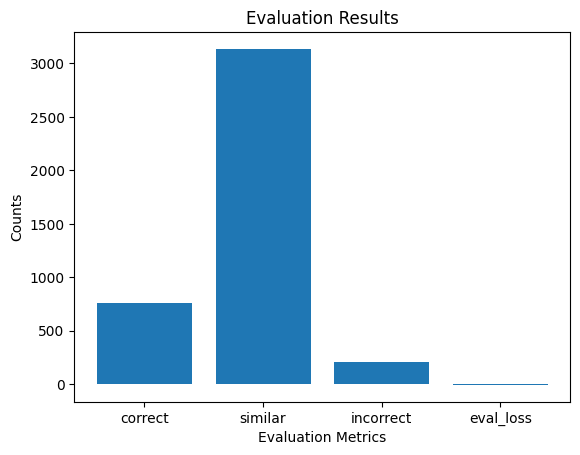

In [17]:
# Plotting
plt.bar(result1.keys(), result1.values())
plt.xlabel('Evaluation Metrics')
plt.ylabel('Counts')
plt.title('Evaluation Results')
plt.show()

In [18]:
# randomly selection 10 instances to predict
random_rows = df.sample(n=10)
data_prediction = convert_to_predict_format(random_rows)

In [19]:
actual_pred = show_actual_pred(model, data_prediction, random_rows)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2900.63it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1581.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1575.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4140.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1626.33it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1664.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2993.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1780.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3310.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
actual_pred_df = pd.DataFrame(actual_pred)
actual_pred_df.head(10)

,actual_question,actual_answer,predicted_answer
0,"What are the symptoms of Keratitis, hereditary ?","What are the signs and symptoms of Keratitis, ...",What
1,What is (are) Bilateral perisylvian polymicrog...,Bilateral perisylvian polymicrogyria (BPP) is ...,B
2,What is (are) erythrokeratodermia variabilis e...,Erythrokeratodermia variabilis et progressiva ...,E
3,What is (are) Andersen-Tawil syndrome ?,Anderson-Tawil syndrome is a disorder that cau...,
4,What is (are) medium-chain acyl-CoA dehydrogen...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...,
5,What is (are) sensorineural deafness and male ...,Sensorineural deafness and male infertility is...,Sensorineural deafness and male infertility is...
6,Who is at risk for Adult Hodgkin Lymphoma? ?,"Age, gender, and Epstein-Barr infection can af...",empty
7,Is Nephrogenic diabetes insipidus inherited ?,How is nephrogenic diabetes insipidus inherite...,How
8,How many people are affected by Lafora progres...,The prevalence of Lafora progressive myoclonus...,The prevalence of Lafora progressive myoclonus...
9,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,Mutations in the ARSB gene cause MPS VI. The A...


#### Computing Bleu and Rough Scores

In [58]:
#_, test_data = train_test_split(df, test_size=0.25, random_state=42)
#formatted_test_data = convert_to_predict_format(test_data[:100])
ref_answers, pred_answers = get_reference_and_predicted_answers(test_data[:100], formatted_test_data, model)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3504.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3469.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1602.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 506.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4510.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1497.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4156.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2920.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2801.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2912.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2232.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1537.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2924.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1441.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1623.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1526.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2995.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3795.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1739.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1567.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2543.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3360.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2864.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2884.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3466.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1460.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4245.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1543.73it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1349.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1606.40it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1660.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1343.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2099.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1579.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3495.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3256.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2055.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1422.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2972.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1390.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1434.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1519.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3269.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1436.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1577.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1444.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2548.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2896.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3004.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2704.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3960.63it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2824.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 589.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1498.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1522.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1565.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3934.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1572.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2981.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3310.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1552.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1418.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1344.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1340.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3034.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3603.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1533.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3214.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2957.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3199.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1438.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1516.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3437.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2855.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1528.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1560.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3666.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1542.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2442.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3310.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2656.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1610.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2920.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3404.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# Calculate BLEU score
bleu_score1 = nltk.translate.bleu_score.corpus_bleu(ref_answers, pred_answers)
print("BLEU Score:", bleu_score1)

BLEU Score: 0.5724428487153937


In [59]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method2  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 0.00033300207953676524


In [24]:
# Initialize Rouge
rouge = Rouge()

# Calculate ROUGE score
rouge_score1 = rouge.get_scores(ref_answers, pred_answers, avg=True, ignore_empty=True)
print("ROUGE Score:", rouge_score1)

ROUGE Score: {'rouge-1': {'r': 0.8368875327908941, 'p': 0.42851959014108326, 'f': 0.4590562708192399}, 'rouge-2': {'r': 0.5511403279260422, 'p': 0.4150003145156717, 'f': 0.4418980258733666}, 'rouge-l': {'r': 0.8368875327908941, 'p': 0.42851959014108326, 'f': 0.4590562708192399}}


### BERT with dropout 0.7

In [36]:
# Define hyperparameters
train_args = {
    'learning_rate': 5e-5,          # Learning rate for optimizer
    'num_train_epochs': 1,          # Number of epochs for training
    'train_batch_size': 16,         # Batch size for training
    'overwrite_output_dir': True,   # Overwrite output directory if it exists
    'reprocess_input_data': True,   # Preprocess input data before training
    'evaluate_during_training': True,  # Evaluate model during training
    'wandb_project': 'NLP_A5',         # Wandb project name for logging (set to None if not using Wandb)
    'save_steps': -1,               # Save model checkpoint every X steps (-1 to disable)
    'n_best_size': 5,
    'dropout': 0.7
}

# Initialize BERT model
bert_model_2 = QuestionAnsweringModel('bert', 'bert-base-cased', args=train_args, use_cuda=True)

# Fine-tune the model on the training data
bert_model_2.train_model(train_df, eval_data=test_df)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 12305/12305 [00:00<00:00, 548113.45it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
correct,▁
eval_loss,▁
global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
incorrect,▁
lr,▇██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
similar,▁
train_loss,▁
Training loss,0.00114
correct,760
eval_loss,-7.0304


Running Epoch 1 of 1:   0%|          | 0/1032 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 4102/4102 [00:26<00:00, 154.85it/s]

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 515089.96it/s]


Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

(1032,
 {'global_step': [1032],
  'correct': [759],
  'similar': [3135],
  'incorrect': [208],
  'train_loss': [0.002518912311643362],
  'eval_loss': [-7.7862926136363635]})

#### Model Evaluation

In [37]:
# Evaluate the model on the testing data
result2, texts = bert_model_2.eval_model(test_df)

# Print evaluation result
print(result2)

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 490185.90it/s]


Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

{'correct': 759, 'similar': 3135, 'incorrect': 208, 'eval_loss': -7.7862926136363635}


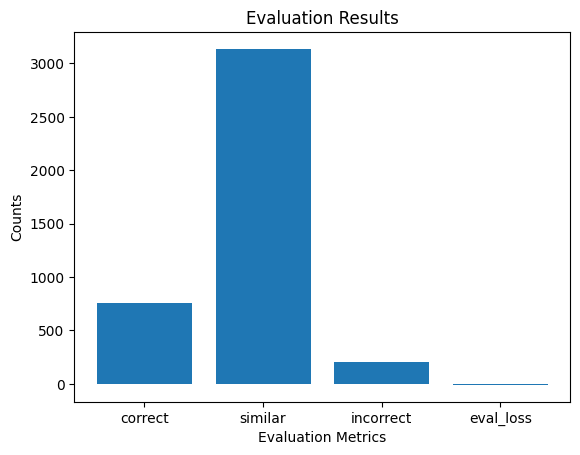

In [38]:
# Plotting
plt.bar(result2.keys(), result2.values())
plt.xlabel('Evaluation Metrics')
plt.ylabel('Counts')
plt.title('Evaluation Results')
plt.show()

In [28]:
actual_pred = show_actual_pred(bert_model_2, data_prediction, random_rows)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2968.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2991.66it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2741.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1297.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3603.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1537.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3429.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
actual_pred_df = pd.DataFrame(actual_pred)
actual_pred_df.head(10)

,actual_question,actual_answer,predicted_answer
0,"What are the symptoms of Keratitis, hereditary ?","What are the signs and symptoms of Keratitis, ...",
1,What is (are) Bilateral perisylvian polymicrog...,Bilateral perisylvian polymicrogyria (BPP) is ...,Signs and symptoms include partial paralysis o...
2,What is (are) erythrokeratodermia variabilis e...,Erythrokeratodermia variabilis et progressiva ...,E
3,What is (are) Andersen-Tawil syndrome ?,Anderson-Tawil syndrome is a disorder that cau...,
4,What is (are) medium-chain acyl-CoA dehydrogen...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...,Medium
5,What is (are) sensorineural deafness and male ...,Sensorineural deafness and male infertility is...,Sensorineural deafness and male infertility is...
6,Who is at risk for Adult Hodgkin Lymphoma? ?,"Age, gender, and Epstein-Barr infection can af...",
7,Is Nephrogenic diabetes insipidus inherited ?,How is nephrogenic diabetes insipidus inherite...,
8,How many people are affected by Lafora progres...,The prevalence of Lafora progressive myoclonus...,The prevalence of Lafora progressive myoclonus...
9,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,tations in the ARSB gene cause MPS VI. The ARS...


#### Computing Bleu and Rough Scores

In [55]:
ref_answers, pred_answers = get_reference_and_predicted_answers(test_data[:100], formatted_test_data, bert_model_2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2420.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3669.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3034.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1628.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2939.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1326.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1559.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1625.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1547.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3685.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2809.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1526.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1503.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1633.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4245.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1365.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1628.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1618.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4080.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3187.16it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1928.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3711.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2621.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3008.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3084.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1249.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1575.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2421.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1632.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1491.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2906.66it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3350.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2912.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1460.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2448.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2721.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3182.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1669.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1862.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2914.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3615.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3137.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 758.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1576.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2707.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1141.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1650.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1430.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2998.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1605.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1470.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1501.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 500.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3097.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2757.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1391.15it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3013.15it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1771.24it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2864.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3795.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3912.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1938.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1462.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1734.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3148.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2813.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1466.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1610.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1743.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1576.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2644.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1573.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1342.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1519.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2083.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1662.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2835.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2790.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2671.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1580.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2803.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2741.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3685.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2866.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1493.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Calculate BLEU score
bleu_score2 = nltk.translate.bleu_score.corpus_bleu(ref_answers, pred_answers)
print("BLEU Score:", bleu_score2)

BLEU Score: 0.5736666018858966


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [57]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method2  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 0.0007007469288179755


In [ ]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method1  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

In [32]:
# Calculate ROUGE score
rouge_score2 = rouge.get_scores(ref_answers, pred_answers, avg=True, ignore_empty=True)
print("ROUGE Score:", rouge_score2)

ROUGE Score: {'rouge-1': {'r': 0.8592238782932592, 'p': 0.41904229367262924, 'f': 0.4702432105014899}, 'rouge-2': {'r': 0.6556942211164944, 'p': 0.3918175573526666, 'f': 0.4377563248457902}, 'rouge-l': {'r': 0.8592238782932592, 'p': 0.41904229367262924, 'f': 0.4702432105014899}}


## Training MobileBERT

### MobileBERT with dropout 0.3

In [39]:
# Define hyperparameters
train_args = {
    'learning_rate': 5e-5,          # Learning rate for optimizer
    'num_train_epochs': 1,          # Number of epochs for training
    'train_batch_size': 16,         # Batch size for training
    'overwrite_output_dir': True,   # Overwrite output directory if it exists
    'reprocess_input_data': True,   # Preprocess input data before training
    'evaluate_during_training': True,  # Evaluate model during training
    'wandb_project': 'NLP_A5',         # Wandb project name for logging (set to None if not using Wandb)
    'save_steps': -1,               # Save model checkpoint every X steps (-1 to disable)
    'n_best_size': 5,
    'dropout': 0.3
}

# Initialize BERT model
mobileBERT_model = QuestionAnsweringModel('mobilebert', 'google/mobilebert-uncased', args=train_args, use_cuda=True)

# Fine-tune the model on the training data
mobileBERT_model.train_model(train_df, eval_data = test_df)

Some weights of MobileBertForQuestionAnswering were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 12305/12305 [00:00<00:00, 544057.33it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training loss,▆▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
correct,▁
eval_loss,▁
global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
incorrect,▁
lr,▇██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
similar,▁
train_loss,▁
Training loss,0.00147
correct,759
eval_loss,-7.78629


Running Epoch 1 of 1:   0%|          | 0/974 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 4102/4102 [00:27<00:00, 150.33it/s]

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 518505.06it/s]


Running Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

(974,
 {'global_step': [974],
  'correct': [0],
  'similar': [4102],
  'incorrect': [0],
  'train_loss': [nan],
  'eval_loss': [nan]})

#### Model Evaluation

In [40]:
# Evaluate the model on the testing data
result_mobileBERT_1, texts = mobileBERT_model.eval_model(test_df)

# Print evaluation result
print(result_mobileBERT_1)

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 554607.54it/s]


Running Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

{'correct': 0, 'similar': 4102, 'incorrect': 0, 'eval_loss': nan}


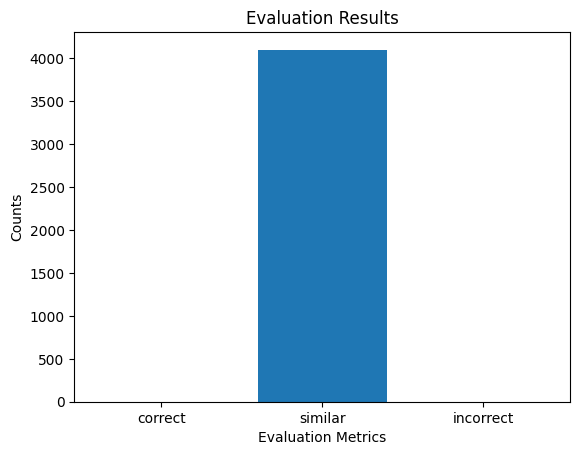

In [41]:
# Plotting
plt.bar(result_mobileBERT_1.keys(), result_mobileBERT_1.values())
plt.xlabel('Evaluation Metrics')
plt.ylabel('Counts')
plt.title('Evaluation Results')
plt.show()

In [42]:
actual_pred = show_actual_pred(mobileBERT_model, data_prediction, random_rows)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2878.73it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2841.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2886.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3054.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3221.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2957.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3008.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3155.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3326.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
actual_pred_df = pd.DataFrame(actual_pred)
actual_pred_df.head(10)

,actual_question,actual_answer,predicted_answer
0,"What are the symptoms of Keratitis, hereditary ?","What are the signs and symptoms of Keratitis, ...",this condition. You can use the MedlinePlus Me...
1,What is (are) Bilateral perisylvian polymicrog...,Bilateral perisylvian polymicrogyria (BPP) is ...,polymicrogyria (BPP) is a rare neurological di...
2,What is (are) erythrokeratodermia variabilis e...,Erythrokeratodermia variabilis et progressiva ...,variabilis et progressiva (EKVP) is a skin dis...
3,What is (are) Andersen-Tawil syndrome ?,Anderson-Tawil syndrome is a disorder that cau...,syndrome. Long QT syndrome is a heart conditio...
4,What is (are) medium-chain acyl-CoA dehydrogen...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...,condition that prevents the body from converti...
5,What is (are) sensorineural deafness and male ...,Sensorineural deafness and male infertility is...,"sensorineural hearing loss, which is caused by..."
6,Who is at risk for Adult Hodgkin Lymphoma? ?,"Age, gender, and Epstein-Barr infection can af...",lymphoma. Anything that increases your risk of...
7,Is Nephrogenic diabetes insipidus inherited ?,How is nephrogenic diabetes insipidus inherite...,"gene, the condition has an X-linked recessive ..."
8,How many people are affected by Lafora progres...,The prevalence of Lafora progressive myoclonus...,myoclonus epilepsy is unknown. Although the co...
9,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,this condition gets its name. Mutations in the...


#### Computing Bleu and Rough Scores

In [60]:
ref_answers, pred_answers = get_reference_and_predicted_answers(test_data[:100], formatted_test_data, mobileBERT_model)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2504.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1433.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2434.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1515.28it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1414.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1463.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3264.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3339.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2380.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1547.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2835.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1279.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3002.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2943.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3489.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2981.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2332.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2138.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3675.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2814.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3134.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3751.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2866.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2957.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3253.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2908.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2704.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1520.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3264.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3483.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2214.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3139.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3294.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2720.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2757.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1395.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2766.69it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2945.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3095.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2600.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2943.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3017.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2184.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1305.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2786.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2814.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2805.55it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3050.40it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2924.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2870.84it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1782.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3276.80it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3030.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3591.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3211.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3587.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3182.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3432.33it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2725.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1527.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3113.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2611.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1709.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1234.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1474.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3052.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3165.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2935.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2757.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2912.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3132.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1463.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3233.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3111.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2631.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2697.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2079.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4052.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2798.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1476.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1441.84it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1527.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2772.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2814.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3855.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3292.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
# Calculate BLEU score
bleu_score = nltk.translate.bleu_score.corpus_bleu(ref_answers, pred_answers)
print("BLEU Score:", bleu_score)

BLEU Score: 0.6228070920387571


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [61]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method2  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 0.0005045531659618329


In [48]:
# Calculate ROUGE score
rouge_score = rouge.get_scores(ref_answers, pred_answers, avg=True, ignore_empty=True)
print("ROUGE Score:", rouge_score)

ROUGE Score: {'rouge-1': {'r': 0.7201236263736263, 'p': 0.20010305589775862, 'f': 0.2830718852040473}, 'rouge-2': {'r': 0.7139047619047619, 'p': 0.1652739363284687, 'f': 0.2371700784030545}, 'rouge-l': {'r': 0.7201236263736263, 'p': 0.20010305589775862, 'f': 0.2830718852040473}}


### MobileBERT with dropout 0.7

In [62]:
# Define hyperparameters
train_args = {
    'learning_rate': 5e-5,          # Learning rate for optimizer
    'num_train_epochs': 1,          # Number of epochs for training
    'train_batch_size': 16,         # Batch size for training
    'overwrite_output_dir': True,   # Overwrite output directory if it exists
    'reprocess_input_data': True,   # Preprocess input data before training
    'evaluate_during_training': True,  # Evaluate model during training
    'wandb_project': 'NLP_A5',         # Wandb project name for logging (set to None if not using Wandb)
    'save_steps': -1,               # Save model checkpoint every X steps (-1 to disable)
    'n_best_size': 5,
    'dropout': 0.7
}

# Initialize BERT model
mobileBERT_model_2 = QuestionAnsweringModel('mobilebert', 'google/mobilebert-uncased', args=train_args, use_cuda=True)

# Fine-tune the model on the training data
mobileBERT_model_2.train_model(train_df, eval_data = test_df)

Some weights of MobileBertForQuestionAnswering were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 12305/12305 [00:00<00:00, 549601.84it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

correct,▁
global_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
incorrect,▁
lr,▇██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
similar,▁
Training loss,nan
correct,0
eval_loss,nan
global_step,974
incorrect,0
lr,0.0


Running Epoch 1 of 1:   0%|          | 0/974 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 4102/4102 [00:25<00:00, 158.03it/s]

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 538145.04it/s]


Running Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

(974,
 {'global_step': [974],
  'correct': [0],
  'similar': [4102],
  'incorrect': [0],
  'train_loss': [nan],
  'eval_loss': [nan]})

#### Model Evaluation

In [63]:
# Evaluate the model on the testing data
result_mobileBERT_2, texts = mobileBERT_model.eval_model(test_df)

# Print evaluation result
print(result_mobileBERT_2)

add example index and unique id: 100%|██████████| 4102/4102 [00:00<00:00, 537875.86it/s]


Running Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

{'correct': 0, 'similar': 4102, 'incorrect': 0, 'eval_loss': nan}


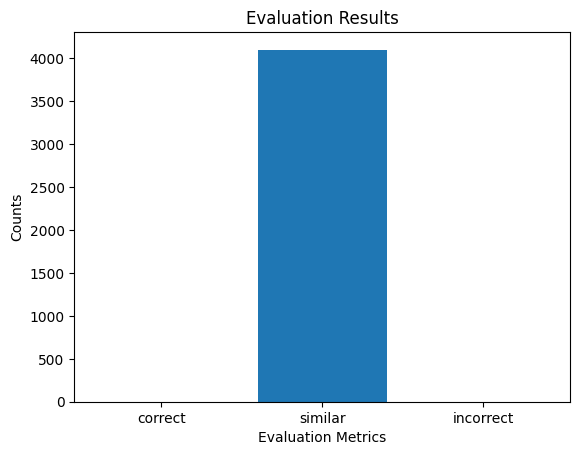

In [64]:
# Plotting
plt.bar(result_mobileBERT_2.keys(), result_mobileBERT_2.values())
plt.xlabel('Evaluation Metrics')
plt.ylabel('Counts')
plt.title('Evaluation Results')
plt.show()

In [65]:
actual_pred = show_actual_pred(mobileBERT_model, data_prediction, random_rows)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2945.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1406.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2861.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3041.55it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1499.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2699.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1592.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2582.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2327.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
actual_pred_df = pd.DataFrame(actual_pred)
actual_pred_df.head(10)

,actual_question,actual_answer,predicted_answer
0,"What are the symptoms of Keratitis, hereditary ?","What are the signs and symptoms of Keratitis, ...",this condition. You can use the MedlinePlus Me...
1,What is (are) Bilateral perisylvian polymicrog...,Bilateral perisylvian polymicrogyria (BPP) is ...,polymicrogyria (BPP) is a rare neurological di...
2,What is (are) erythrokeratodermia variabilis e...,Erythrokeratodermia variabilis et progressiva ...,variabilis et progressiva (EKVP) is a skin dis...
3,What is (are) Andersen-Tawil syndrome ?,Anderson-Tawil syndrome is a disorder that cau...,syndrome. Long QT syndrome is a heart conditio...
4,What is (are) medium-chain acyl-CoA dehydrogen...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...,condition that prevents the body from converti...
5,What is (are) sensorineural deafness and male ...,Sensorineural deafness and male infertility is...,"sensorineural hearing loss, which is caused by..."
6,Who is at risk for Adult Hodgkin Lymphoma? ?,"Age, gender, and Epstein-Barr infection can af...",lymphoma. Anything that increases your risk of...
7,Is Nephrogenic diabetes insipidus inherited ?,How is nephrogenic diabetes insipidus inherite...,"gene, the condition has an X-linked recessive ..."
8,How many people are affected by Lafora progres...,The prevalence of Lafora progressive myoclonus...,myoclonus epilepsy is unknown. Although the co...
9,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,this condition gets its name. Mutations in the...


#### Computing Bleu and Rough Scores

In [67]:
ref_answers, pred_answers = get_reference_and_predicted_answers(test_data[:100], formatted_test_data, mobileBERT_model_2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1337.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3146.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3206.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2922.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3146.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1515.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1510.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2434.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3326.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2886.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2566.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1321.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2888.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2866.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3010.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2792.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1728.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3415.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2757.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2888.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2659.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2766.69it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1591.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1527.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2714.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4056.39it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3093.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2922.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3231.36it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1193.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2845.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2902.63it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1331.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2757.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2910.69it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3363.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3238.84it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3504.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2898.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2759.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2955.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1555.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3139.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3045.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1448.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2792.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2931.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1417.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3269.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2847.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2768.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3165.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2904.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2886.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3226.39it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2884.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1387.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2651.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3440.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2855.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2785.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1427.12it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1497.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2166.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2681.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2517.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2814.97it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2768.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2993.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1311.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2768.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3221.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3100.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2964.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2764.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3028.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2552.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1526.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2634.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2900.63it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3318.28it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2962.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3300.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1357.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2786.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3518.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [68]:
# Calculate BLEU score
bleu_score = nltk.translate.bleu_score.corpus_bleu(ref_answers, pred_answers)
print("BLEU Score:", bleu_score)

BLEU Score: 0.6191264951151664


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [69]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method2  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 0.0004531209051993948


In [70]:
# Calculate ROUGE score
rouge_score = rouge.get_scores(ref_answers, pred_answers, avg=True, ignore_empty=True)
print("ROUGE Score:", rouge_score)

ROUGE Score: {'rouge-1': {'r': 0.8175242424242424, 'p': 0.22227691995549076, 'f': 0.3177145907662498}, 'rouge-2': {'r': 0.7887683284457477, 'p': 0.18124193759516408, 'f': 0.2645835015861094}, 'rouge-l': {'r': 0.8175242424242424, 'p': 0.22227691995549076, 'f': 0.3177145907662498}}


## Training Roberta

Truncating dataset as Roberta takes very much time and cost on 16000 rows

In [76]:
short_formatted_data = formatted_data[:1000]
short_train_data, short_test_data = train_test_split(short_formatted_data, test_size=0.25, random_state=42)

### Roberta with dropout 0.3

In [78]:
# Define hyperparameters
train_args = {
    'learning_rate': 5e-5,          # Learning rate for optimizer
    'num_train_epochs': 1,          # Number of epochs for training
    'train_batch_size': 16,         # Batch size for training
    'overwrite_output_dir': True,   # Overwrite output directory if it exists
    'reprocess_input_data': True,   # Preprocess input data before training
    'evaluate_during_training': True,  # Evaluate model during training
    'wandb_project': 'NLP_A5',         # Wandb project name for logging (set to None if not using Wandb)
    'save_steps': -1,               # Save model checkpoint every X steps (-1 to disable)
    'n_best_size': 5,
    'dropout': 0.3
}

# Initialize model
roberta_model_1 = QuestionAnsweringModel('roberta', 'roberta-base', args=train_args, use_cuda=True)

# Fine-tune the model on the training data
roberta_model_1.train_model(short_train_data, eval_data = short_test_data)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
add example index and unique id: 100%|██████████| 750/750 [00:00<00:00, 468044.64it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

correct,▁
global_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
incorrect,▁
lr,▇██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
similar,▁
Training loss,nan
correct,0
eval_loss,nan
global_step,974
incorrect,0
lr,0.0


Running Epoch 1 of 1:   0%|          | 0/54 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 250/250 [00:01<00:00, 165.29it/s]

add example index and unique id: 100%|██████████| 250/250 [00:00<00:00, 330260.16it/s]


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

(54,
 {'global_step': [54],
  'correct': [19],
  'similar': [230],
  'incorrect': [1],
  'train_loss': [2.121490478515625],
  'eval_loss': [-6.108072916666667]})

### Model Evaluation

In [80]:
# Evaluate the model on the testing data
result_roberta, texts = roberta_model_1.eval_model(short_test_df)

# Print evaluation result
print(result_roberta)

add example index and unique id: 100%|██████████| 250/250 [00:00<00:00, 310873.41it/s]


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

{'correct': 19, 'similar': 230, 'incorrect': 1, 'eval_loss': -6.108072916666667}


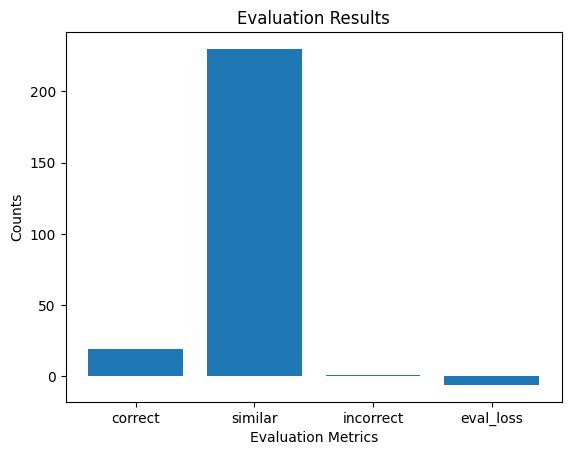

In [81]:
# Plotting
plt.bar(result_roberta.keys(), result_roberta.values())
plt.xlabel('Evaluation Metrics')
plt.ylabel('Counts')
plt.title('Evaluation Results')
plt.show()

In [83]:
actual_pred = show_actual_pred(roberta_model_1, data_prediction, random_rows)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3028.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3631.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3452.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1337.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3004.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3474.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3218.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
actual_pred_df = pd.DataFrame(actual_pred)
actual_pred_df.head(10)

,actual_question,actual_answer,predicted_answer
0,"What are the symptoms of Keratitis, hereditary ?","What are the signs and symptoms of Keratitis, ...","What are the signs and symptoms of Keratitis, ..."
1,What is (are) Bilateral perisylvian polymicrog...,Bilateral perisylvian polymicrogyria (BPP) is ...,"seizures. In most cases, mild to severe intell..."
2,What is (are) erythrokeratodermia variabilis e...,Erythrokeratodermia variabilis et progressiva ...,Erythrokeratodermia variabilis et progressiva ...
3,What is (are) Andersen-Tawil syndrome ?,Anderson-Tawil syndrome is a disorder that cau...,Anderson-Tawil syndrome is a disorder that cau...
4,What is (are) medium-chain acyl-CoA dehydrogen...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...,Medium-chain acyl-CoA dehydrogenase (MCAD) def...
5,What is (are) sensorineural deafness and male ...,Sensorineural deafness and male infertility is...,Sensorineural deafness and male infertility is...
6,Who is at risk for Adult Hodgkin Lymphoma? ?,"Age, gender, and Epstein-Barr infection can af...","Age, gender, and Epstein-Barr infection can af..."
7,Is Nephrogenic diabetes insipidus inherited ?,How is nephrogenic diabetes insipidus inherite...,How is nephrogenic diabetes insipidus inherite...
8,How many people are affected by Lafora progres...,The prevalence of Lafora progressive myoclonus...,The prevalence of Lafora progressive myoclonus...
9,What are the genetic changes related to mucopo...,Mutations in the ARSB gene cause MPS VI. The A...,name. Mutations in the ARSB gene reduce or com...


### Computing Bleu and Rough Scores

In [85]:
ref_answers, pred_answers = get_reference_and_predicted_answers(test_data[:100], formatted_test_data, roberta_model_1)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2964.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2700.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1361.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1534.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1565.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3426.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1563.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4341.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2657.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3945.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2734.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2798.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1341.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2796.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1618.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3415.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3366.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2989.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1526.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1922.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1476.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1423.73it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3454.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1411.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2947.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3342.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2134.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2744.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2647.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1562.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4419.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1710.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1441.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3248.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3443.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3167.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1381.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1714.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1523.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2774.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1547.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2918.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1728.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1555.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3187.16it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2826.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2522.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1540.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1451.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4036.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2861.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3318.28it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1624.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2796.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1424.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3292.23it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1554.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3251.40it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2974.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1643.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1468.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3883.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1977.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1474.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1681.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3938.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1453.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2785.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1460.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1498.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1646.12it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1589.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1916.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3072.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1631.39it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1438.38it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1278.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1602.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2926.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1353.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3377.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2595.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1586.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1479.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3591.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1372.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1621.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2968.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3618.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
# Calculate BLEU score
bleu_score = nltk.translate.bleu_score.corpus_bleu(ref_answers, pred_answers)
print("BLEU Score:", bleu_score)

BLEU Score: 0.5658118128779986


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [87]:
# Calculate BLEU score with smoothing function
smoothing_function = SmoothingFunction().method2  # You can choose different methods
bleu_score = corpus_bleu(ref_answers, pred_answers, smoothing_function=smoothing_function)

print("BLEU Score with Smoothing:", bleu_score)

BLEU Score with Smoothing: 0.00025609173650382463


In [88]:
# Calculate ROUGE score
rouge_score = rouge.get_scores(ref_answers, pred_answers, avg=True, ignore_empty=True)
print("ROUGE Score:", rouge_score)

ROUGE Score: {'rouge-1': {'r': 0.99, 'p': 0.4879974587862238, 'f': 0.5929957291053778}, 'rouge-2': {'r': 0.97, 'p': 0.4403901869763894, 'f': 0.5379649772083277}, 'rouge-l': {'r': 0.99, 'p': 0.4879974587862238, 'f': 0.5929957291053778}}
